# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

74

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 台北萬華 華西街夜市 小王、阿義、源芳', 'date': '10/12', 'author': 'scissorstone', 'link': '/bbs/Food/M.1602459971.A.7DC.html', 'text': '\n圖文連結: \n\n1. 阿義滷肉飯\n地址: 台北市萬華區華西街15-1號\n電話: 0958 860 213\n營業時間: 11:00–20:00 (星期一公休)\n平均價位: 30-300\n\n滷肉飯\n手切皮油為主的肉燥\n膠質含量豐富\n個人口味上覺得紅蔥頭味道占比過重\n口味上偏淡，希望再鹹甜一些\n\n\n清燙魚皮\n魚皮有一點點腥味\n但搭配化學芥末與鹹甜醬油膏後\n問題少了很多\n( 對，沒錯虱目魚就是要搭化學芥末)\n\n\n滷白菜\n加入膨皮一起滷的古早風味\n切絲豆皮提供不同的口感\n但入味程度還是不足\n\n\n油豆腐、豆腐、滷鴨蛋\n油豆腐好好吃，兩塊10元佛心價\n香氣十足沒有油耗味\n醬汁也充分入味！\n\n豆腐與鴨蛋沒有滷透很普通\n\n————————————————————————————————\n\n2. 小王煮瓜（原小王清湯瓜仔肉）\n地址: 台北市萬華區華西街17之4號\n電話: 02 2370 7118\n營業時間: 09:30–20:00 (星期二公休)\n平均價位: 30-300\n\n\n滷肉飯、滷鴨蛋\n照片中就可看到醬色明顯比阿義重\n個人口味上，甜味稍嫌不足\n讓醬汁吃起來有些死鹹\n吃完後舌頭會殘留鹹味的麻痺感\n\n鴨蛋入味好吃\n\n\n瓜仔肉湯\n豬後腿肉做成的肉羹口感很好\n明確的肉感感受得出真材實料\n瓜仔肉湯再甜一些就好了 (很台南人的發言)\n\n\n————————————————————————————————\n\n\n3. 源芳刈包\n地址: 台北市萬華區華西街17-2號\n電話: 02 2381 0249\n營業時間: 12:00–22:00 (星期一公休)\n平均價位: 50-100\n\n\n刈包 50元\n刈包還可以\n但跟記憶中的味道已經相去甚遠\n首先是主角焢肉\n乍看之下，醬色不深 (跟幾年前相比)\n滷汁沒有完全滷透\n重要的配角酸菜\n跟別人不同的是這裡的酸菜\n包進麵皮

In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push:  
title: [食記] 台南 南區 義大利麵 食上主義餐酒館 
date: 10/12 
author: hibabino 
link: /bbs/Food/M.1602463960.A.A17.html 
text: 
   餐廳名稱：食上主義餐酒館 The 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])


   餐廳名稱：食上主義餐酒館 The Sober Foodie
   消費時間：2020年/09月
   地址：台南市南區體育路 21 巷 5-1 號
   電話：06 6213 0456
   營業時間：17:00 – 23:00
   每人平均價位：260~600
   可否刷卡：可
   有無包廂：無
   推薦菜色：白酒蒜香吻仔魚蛤蜊

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

圖文版：

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

晚上 5 點才開始營業至半夜 11 點的台南老宅餐酒館 —— 『 食上主義餐酒館 The Sober Foodie 』，位在台南棒球場附近，生意好到超級難訂位，如果是臨時想要吃，真的可以跟你說不用鬧了，因為真的是人多到臨時來也是座無虛席、吃不到的那種狀況。店內提供義大利麵、燉飯、排餐及各式各樣的小點菜色，份量偏多，適合跟朋友一起分食享用，用餐氣氛也很棒，約會也蠻適合的哦！
食上主義餐酒館位在台南棒球場後頭的小巷中，走一段路就有停車場可以停車。從外觀看起來，是一座老老的舊建築，朋友的 9 歲女兒一起來，說還以為是來到古蹟，真是太可愛了。

店裡頭，昏黃的燈光，深褐色系的裝潢，餐酒館的氣氛非常好。用歐洲風格的特色牆面作為主題牆，幾張歐洲建築的掛畫掛在牆上，簡單卻已經能夠營造出異國風情。

這天我們被安排的位置在 B1 ，從店中間的旋轉樓梯就可以走下去。實在沒想到，店裡頭居然有一座旋轉樓梯，結構本身的美讓店家的特色處又添一樁。如果這以前是住宅，那一定是豪宅來著。
沙發座位，特別有 lounge bar 的感覺。好喜歡這一區牆面與天花板的莫蘭迪色，顏色色調相當柔和。
我們座位旁邊的掛畫，一眼我就看出來它是英國，英國大笨鐘、倫敦塔橋、西敏寺...blabla，畢竟我也是去過英國遊學還有英國自由行過兩次的人呀。看完環境，接下來就是我們這次五個人吃的餐點分享囉！

羊乳酪帕瑪森火腿沙拉 $190
另外有一盅青醬可以搭配，具有松子及羅勒香氣的青醬，幫沙拉增添了不少風味。朋友說加了青醬更好吃，但我覺得原本就很好吃了：Ｐ

西式香辣蒜香蝦 $270
朋友超推的香辣蒜香蝦，看起來辣椒滿滿，但其實辣椒籽都已經被去掉了，所以吃起來根本就沒有什麼辣可言，辣椒是都可以直接嚼起來嚼出香氣的那種。一份蝦子約莫有 15 隻左右

In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.540 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n 餐廳名稱：Coffee underwater 特色創意咖啡(附菜單)\n 消費...,餐廳 名稱 特色 創意 咖啡 附 菜單 消費 時間 年 月 地址 台北市 中山區 龍江路 巷...
1,\n 餐廳名稱：一品魚麵\n 消費時間：2020年/10月\n 地址：桃園市中壢...,餐廳 名稱 一品 魚 麵 消費 時間 年 月 地址 桃園市 中壢區 成章 二街 號 電話 營...


In [11]:
raw[5]

'\n   餐廳名稱：河南砂鍋手工扯麵\n   消費時間：2020年/7月\n   地址：新北市三峽區光明路26號\n   電話：02-2671 2067\n   營業時間：10:30~20:30 週四休\n\n\n\n\n有圖無音樂版\n\n這間扯麵是在 ninesky九天喝咖啡找晚餐找到的，位於三峽市區靠近老街的地方，交通算\n是方便\n\n\n\n\n一個店面裡面有很多位置，找好位置填好菜單交出就可以\n\n\n\n菜單，牛肉麵100，排骨麵80，番茄蛋麵60，湯麵40，可以選扯麵、冬粉跟細麵，也有小\n菜等可選，點了牛肉麵、排骨麵、雜醬麵跟豆乾與海帶。不過等叫出菜單後才知道大家都\n點番茄蛋麵!\n\n\n送上來的豆干跟海帶，還OK\n\n\n牛肉麵，湯底會帶點辣，有蘿蔔跟一點點青菜，牛肉有五塊，吃起來有厚度也不會柴、麵\n條非常寬，帶有嚼勁，扯麵的份量蠻多會有點吃不完\n\n\n\n雜醬麵有種維力的感覺有一點點豆干跟豆瓣，但味道是好的，帶點鹹甜又讓麵條吸附醬\n汁，但沒吃到辣的味道就是，很快就吃完這一碗麵，份量也是吃完會飽\n\n\n\n\n排骨麵，排骨是很大塊那種可以嗑的，也是蠻好吃\n\n\n\n\n最後就是還不錯的麵店，扯麵蠻特別，看到大家都點番茄蛋麵，下次來也想吃這個看看\n\n--\n\n\n    女\n\n才符\n─子個\n\n--\n'

In [12]:
raw_normalized[4]

'餐廳 名稱 参火 木鮮切 牛排 消費 時間 年 月 地址 花蓮縣 花蓮市 仁愛街 號 樓 電話 營業 時間 平 假日 週二 週一 公休 網誌 圖文 版 位於 仁愛街 上 的 參火木 牛排館 從 花蓮 火車站 過來 約 分鐘 左右 車程 旁邊 不遠 就是 花蓮 文創 園區 舊鐵道 徒步區 以及 民國 路 美食 商圈 等 景點 是 個 滿 熱鬧 的 區塊 如果 開車 過來 的 除了 自由街 停車場 文創 停車場 以及 收費 停車格 之外 還有 座 福廣 仁愛 停車場 能 多 加利 用 只要 花點 小錢 不至於 太 難 停車 店內 的 用餐 空間 與 桌數 其實 並不算 多 因此 如果 有 打算 要 前來 用餐 建議 事先 訂位 會 比較 保險 而 整體 裝潢 色調 雖然 簡 但 在 強弱 適中 的 燈光 搭配 下 還是 讓 人 覺得 舒服 當初 就 主打 著以 高價 位 牛排 在 花蓮 展店 而 除了 能 自行 決定 要 吃 多少 分量 以克 計價 之外 還有 依照 熟成 方式 分為 乾式 與 濕式 熟成 兩種 的 美國 日本 澳洲 不同 國家 各 部位 的 肉品 能 選擇 想當然耳 在 價位 上 就 會 屬於 比較 高檔 的 那種 價錢 如果 有點 到 鮮切 牛排 系列 的 點完 餐就會 被 引導到 櫃台 去 選擇 想 吃 的 分量 像 我 今天 選擇 的 紐約客 就 會 先 切掉 多餘 脂肪 後 再 秤重 計價 精選 開胃菜 凱薩 醬 鮮蔬 沙拉 蝦子 已經 去殼 簡單 汆燙 後 就 能 引出 鮮蝦 原本 的 味道 而 灑上 香料 後 的 烤 香菇 與 底下 清爽 的 木耳 搭配 也 滿 好吃 的 而 沙拉 有 和風醬 以及 凱薩 醬 兩種 能 選擇 吃起來 雖不算 特別 但 也 是 清爽 開胃 苜蓿芽 也 令人 感到 健康 法式 野菇 奶香 濃湯 濃湯 部分則 是 有 野菇 以及 南瓜 濃湯 兩種 法式 野菇 奶香 濃湯 喝 起來 很 像 是 嬰兒 食品 般 稠稠 那種 也 可以 說 很 像 是 穀物 麥片 的 口感 相當 不錯 不過 以 我 平常 口味 來 說 兩種 湯品 來屬 中 間 偏 鹹 但 見仁見智 就 僅供 參考 手工 歐式 麵包 原本 以為 是 普通 會 爆漿 的 那種 奶油 小 餐包 但 夾雜 著 紅藜 麥 的 手工 麵包 能 吃到 麵粉 香氣 

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n   餐廳名稱：Coffee underwater 特色創意咖啡(附菜單)\n   消費時間：109年9月\n   地址：台北市中山區龍江路106巷4號\n   電話： 02 2506 6520\n   營業時間：9:30~19:00\n   每人平均價位：130\n   有無包廂：無\n   推薦菜色：髒髒\n\n\n圖文好讀板：\n\n\n辛苦地買完犁記，吃完 東館牛 後，來到了 Coffee underwater\n簡單的外型設計，原以為是間小店，沒想到一推開門，別有一番洞天\n\n店外有一桌裡面的空間則是通到隔壁巷，感覺是兩間打成一間，很長，\n但因為兩面都有採光，所以不至於過度昏暗\n\n藍色的色彩，妝點整個店家，連外帶杯抑是如此\n\n櫥窗內的甜點\n\n櫃台旁有聞香罐，可選擇自己喜愛的口味\n\n\n除了販賣的商品外，也提供書本，很適合在這待上一整天\n\n\n販賣貓、犬相關產品\n\n水是自助式的，但因為水瓶容量較小，且龍頭位置較高所以到後面裝水都要用傾斜\n的方式，有些不便\n\n\nMENU\n\n 創意飲品  濃縮 茶  氣泡飲\n\n\n單品手沖\n\n\n髒髒 130元\n本想說不就是濃縮加牛奶嗎？怎麼和拿鐵價位差那麼多，後來詢問之下才知道他的濃縮\n液是用冷萃的方式做萃取，所以口感較為不一樣。\n拿到成品後，除了飲料是冰的外，杯墊整個一直到喝完都是維持冰冰的狀態，且\n喝起來的口感很濃醇，咖啡味很棒，很順口\n\n\n柑霖 150元\n這杯其實是因為看到GOOGLE 評價人家貼的照片才點的，因為挺吸睛的，所以詢問之下才\n知道這叫柑霖，立馬點一杯~~\n飲料送上來時，店家有特別交代別攪拌太過頭，不然會溢出來~~~然後上頭的果乾\n可食用，但要避免吃到皮，因為會苦！一開始喝它真的是小心翼翼， 酸酸\n苦苦很多層次，後來待飲料沒那麼滿時，就開始攪拌，結果飲料就波波波，\n一直滿出來，恰好到杯緣而已，後來我才意會到，這是加了氣泡水Bubble\n\n由於點餐時沒仔細看MENU裡面的介紹，只看人家的照片就點，個人不愛氣泡飲，所以\n不是飲料不好喝，而是我不愛氣泡飲，若是喜歡氣泡飲的應該會喜歡它，不然網路上\n不會那麼多人推薦\n\n\n原味起士蛋糕 120元\n蠻濕潤的起士蛋糕，不會乾，吃起來帶些梅子粉味。\n店家還很用心在一旁灑下一些碎花

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n   餐廳名稱Coffee underwater 特色創意咖啡附菜單\n   消費時間109年9月\n   地址台北市中山區龍江路106巷4號\n   電話 02 2506 6520\n   營業時間9301900\n   每人平均價位130\n   有無包廂無\n   推薦菜色髒髒\n\n\n圖文好讀板\n\n\n辛苦地買完犁記吃完 東館牛 後來到了 Coffee underwater\n簡單的外型設計原以為是間小店沒想到一推開門別有一番洞天\n\n店外有一桌裡面的空間則是通到隔壁巷感覺是兩間打成一間很長\n但因為兩面都有採光所以不至於過度昏暗\n\n藍色的色彩妝點整個店家連外帶杯抑是如此\n\n櫥窗內的甜點\n\n櫃台旁有聞香罐可選擇自己喜愛的口味\n\n\n除了販賣的商品外也提供書本很適合在這待上一整天\n\n\n販賣貓犬相關產品\n\n水是自助式的但因為水瓶容量較小且龍頭位置較高所以到後面裝水都要用傾斜\n的方式有些不便\n\n\nMENU\n\n 創意飲品  濃縮 茶  氣泡飲\n\n\n單品手沖\n\n\n髒髒 130元\n本想說不就是濃縮加牛奶嗎怎麼和拿鐵價位差那麼多後來詢問之下才知道他的濃縮\n液是用冷萃的方式做萃取所以口感較為不一樣\n拿到成品後除了飲料是冰的外杯墊整個一直到喝完都是維持冰冰的狀態且\n喝起來的口感很濃醇咖啡味很棒很順口\n\n\n柑霖 150元\n這杯其實是因為看到GOOGLE 評價人家貼的照片才點的因為挺吸睛的所以詢問之下才\n知道這叫柑霖立馬點一杯\n飲料送上來時店家有特別交代別攪拌太過頭不然會溢出來然後上頭的果乾\n可食用但要避免吃到皮因為會苦一開始喝它真的是小心翼翼 酸酸\n苦苦很多層次後來待飲料沒那麼滿時就開始攪拌結果飲料就波波波\n一直滿出來恰好到杯緣而已後來我才意會到這是加了氣泡水Bubble\n\n由於點餐時沒仔細看MENU裡面的介紹只看人家的照片就點個人不愛氣泡飲所以\n不是飲料不好喝而是我不愛氣泡飲若是喜歡氣泡飲的應該會喜歡它不然網路上\n不會那麼多人推薦\n\n\n原味起士蛋糕 120元\n蠻濕潤的起士蛋糕不會乾吃起來帶些梅子粉味\n店家還很用心在一旁灑下一些碎花瓣\n\n\n\n總評\n在龍江路周遭的巷子中不乏類似有特色的咖啡店住這兒的人真幸福\n店家給人的感覺是舒適的畢竟寬敞的空間桌與桌間不會靠得太

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 74, '時間': 71, '是': 71, '地址': 67, '營業': 67, '也': 67, '在': 67, '有': 66, '了': 64, '電話': 63, '號': 62, '就': 62, '消費': 60, '很': 60, '人': 60, '餐廳': 59, '會': 59, '都': 58, '來': 58, '吃': 58, '可以': 57, '名稱': 55, '不': 55, '月': 54, '但': 54, '上': 52, '我': 51, '年': 50, '價位': 48, '口感': 48, '說': 46, '到': 44, '好': 44, '覺得': 44, '圖文': 43, '和': 43, '不錯': 43, '每人': 42, '就是': 42, '讓': 42, '版': 42, '平均': 41, '要': 41, '沒有': 41, '又': 41, '推薦': 39, '口味': 39, '不過': 39, '無': 38, '因為': 38, '好吃': 38, '搭配': 37, '用餐': 37, '還有': 37, '菜單': 36, '後': 36, '元': 36, '我們': 36, '味道': 36, '想': 36, '店家': 35, '才': 35, '一': 35, '真的': 35, '吃起來': 35, '以': 35, '特別': 34, '個': 34, '比較': 34, '可': 33, '小': 33, '還': 33, '非常': 33, '還是': 33, '多': 33, '雖然': 33, '中': 33, '有點': 33, '店內': 33, '有無': 32, '喜歡': 32, '跟': 32, '刷卡': 32, '像': 32, '包廂': 31, '菜色': 31, '沒': 31, '不會': 31, '餐點': 31, '再': 31, '對': 31, '去': 31, '所以': 30, '選擇': 30, '他': 30, '時': 30, '可否': 30, '感覺': 29, '一樣': 29, '另外': 29, '與': 29, '更': 29, '台北市': 28, '除了': 28, 

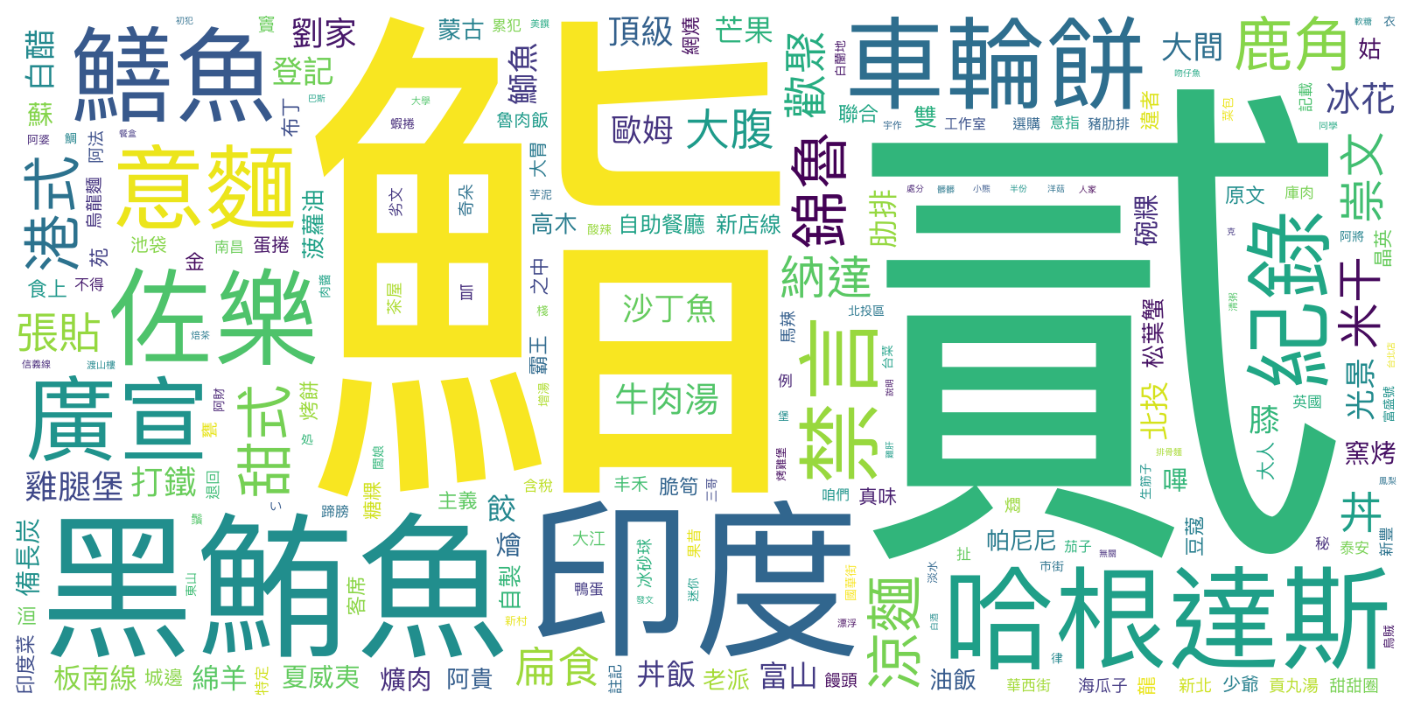

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
